In [1]:
import torch
import matplotlib.pyplot as plt
from tailnflows.models import flows
from functools import partial
from nflows.transforms.standard import IdentityTransform

### Univariate Densities

In [2]:
base_transform = partial(
    flows.base_nsf_transform,
    depth=2,
    tail_bound=3.,
    num_bins=3
)

base_transform = lambda dim: [IdentityTransform()]

In [3]:
base_flow = flows.build_base_model(
    1,
    "density_estimation",
    base_transformation_init=base_transform,
)

ttf_flow = flows.build_ttf_m(
    1,
    "density_estimation",
    base_transformation_init=base_transform,
    model_kwargs=dict(
        pos_tail_init=torch.tensor([0.1]),
        neg_tail_init=torch.tensor([0.1]),
    )
)

ttf_2scale_flow = flows.build_ttf_2scale_m(
    1,
    "density_estimation",
    base_transformation_init=base_transform,
    model_kwargs=dict(
        pos_tail_init=torch.tensor([0.1]),
        neg_tail_init=torch.tensor([0.1]),
        neg_scale_init=torch.tensor([0.2]),
    )
)

gtaf_flow = flows.build_gtaf(
    1,
    "density_estimation",
    base_transformation_init=base_transform,
    model_kwargs=dict(
        tail_init=torch.tensor([10.]),
    )
)

comet_flow = flows.build_comet(
    1,
    "density_estimation",
    base_transformation_init=base_transform,
    model_kwargs=dict(
        data=torch.distributions.StudentT(10., 0., 1.).sample([1000, 1]),
        fix_tails=True,
        tail_init=torch.tensor([.1])
    )
)

flow_models = {
    'base': base_flow,
    'ttf': ttf_flow,
    'ttf_2scale_flow': ttf_2scale_flow,
    'gtaf': gtaf_flow,
    'comet': comet_flow
}

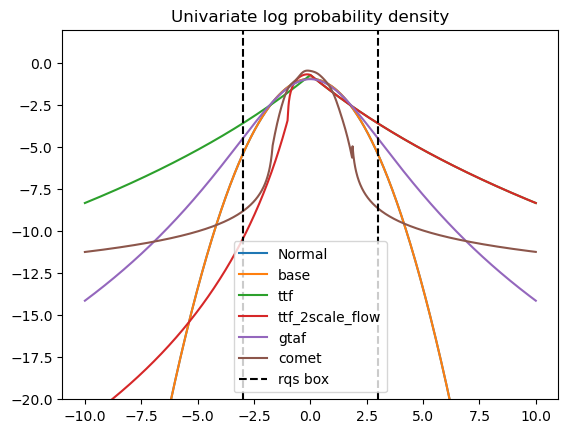

In [4]:
# do the densities look sensible, ie normalised and with correct tails
with torch.no_grad():
    x_inspect = torch.linspace(-10, 10, 1000).reshape(-1, 1)
    plt.plot(x_inspect, torch.distributions.Normal(0., 1.).log_prob(x_inspect), label='Normal')
    for label, flow in flow_models.items():
        plt.plot(x_inspect, flow.log_prob(x_inspect), label=label)

    plt.axvline(3., linestyle='--', c='black')
    plt.axvline(-3., linestyle='--', c='black', label='rqs box')
    plt.legend()
    plt.title('Univariate log probability density')
    plt.ylim([-20, 2])

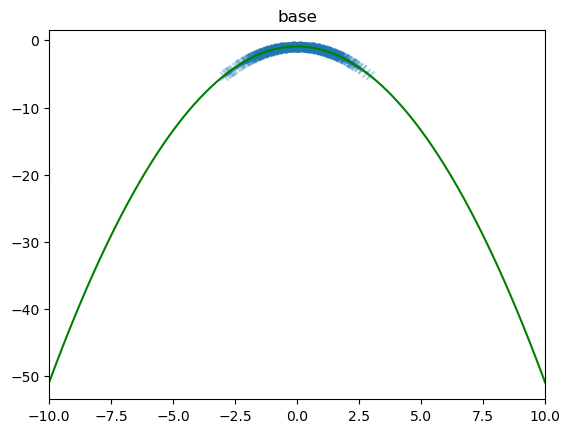

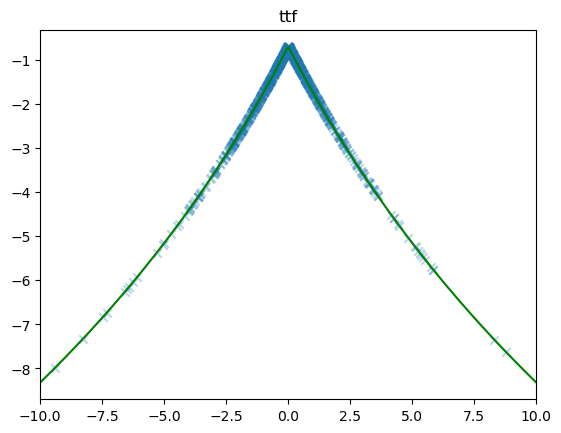

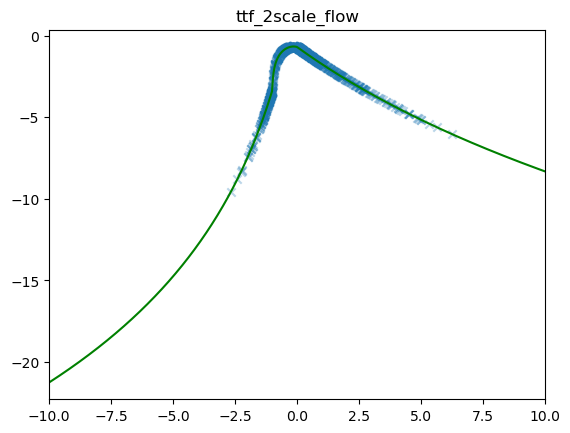

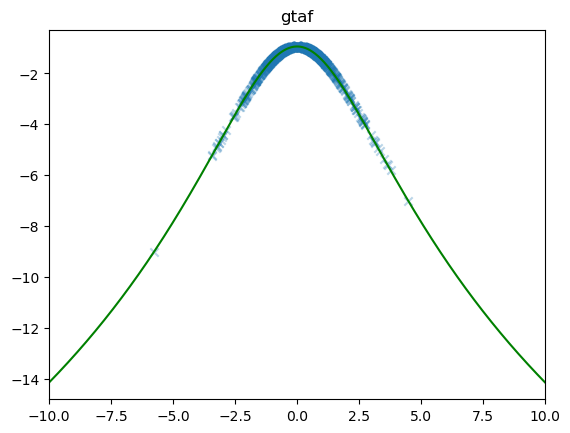

In [5]:
# does VI density match DE density 
with torch.no_grad():
    x_inspect = torch.linspace(-10, 10, 1000).reshape(-1, 1)
    for label, flow in flow_models.items():
        if label == 'comet':
            continue
        x_q, log_q_x = flow.sample_and_log_prob(1000)
        plt.scatter(x_q, log_q_x, alpha=0.3, marker='x')
        plt.plot(x_inspect, flow.log_prob(x_inspect), c='green')
        plt.title(label)
        plt.xlim([-10, 10])
        plt.show()

### Multivariate density

In [8]:
from nflows.transforms.standard import IdentityTransform
base_transforms = partial(
    flows.base_nsf_transform,
    depth=1,
    tail_bound=3.,
    num_bins=3
)

base_transforms = lambda dim: [IdentityTransform()]

base_flow = flows.build_base_model(
    2,
    "density_estimation",
    base_transformation_init=base_transforms,
)

ttf_flow = flows.build_ttf_m(
    2,
    "density_estimation",
    base_transformation_init=base_transforms,
    model_kwargs=dict(
        pos_tail_init=torch.tensor([0.1, 0.1]),
        neg_tail_init=torch.tensor([0.1, 0.1]),
    )
)

ttf_flow_autoreg = flows.build_ttf_autoreg(
    2,
    "density_estimation",
    base_transformation_init=base_transforms,
    model_kwargs=dict()
)

ttf_2scale_flow = flows.build_ttf_2scale_m(
    2,
    "density_estimation",
    base_transformation_init=base_transform,
    model_kwargs=dict(
        pos_tail_init=torch.tensor([0.1, 0.1]),
        neg_tail_init=torch.tensor([0.1, 0.1]),
        neg_scale_init=torch.tensor([0.2, 1.]),
    )
)


gtaf_flow = flows.build_gtaf(
    2,
    "density_estimation",
    base_transformation_init=base_transforms,
    model_kwargs=dict(
        tail_init=torch.tensor([10., 10.]),
    )
)

mtaf_flow = flows.build_mtaf(
    2,
    "density_estimation",
    base_transformation_init=base_transforms,
    model_kwargs=dict(
        tail_init=torch.tensor([10., 0.]),
    )
)

comet_flow = flows.build_comet(
    2,
    "density_estimation",
    base_transformation_init=base_transforms,
    model_kwargs=dict(
        data=torch.distributions.StudentT(10., 0., 1.).sample([1000, 2]),
        fix_tails=True,
        tail_init=torch.tensor([0.1, 0.1])
    )
)

bivariate_flow_models = {
    'base': base_flow,
    'ttf': ttf_flow,
    'ttf_autoreg': ttf_flow_autoreg,
    'ttf_2scale_flow': ttf_2scale_flow,
    'gtaf': gtaf_flow,
    'mtaf': mtaf_flow,
    'comet': comet_flow
}

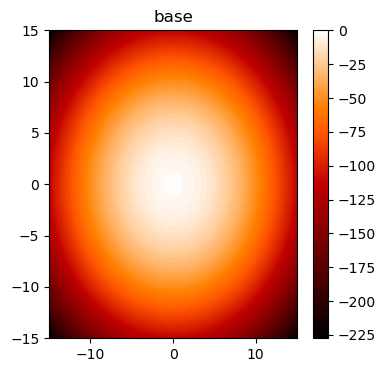

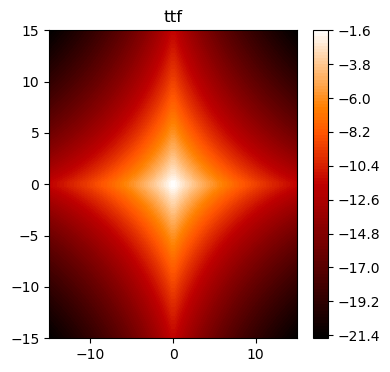

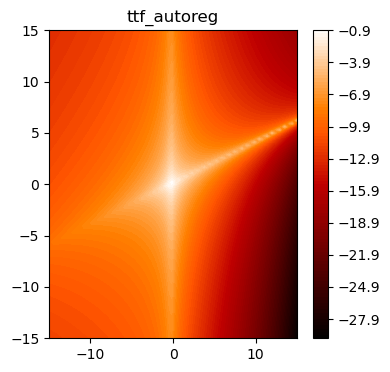

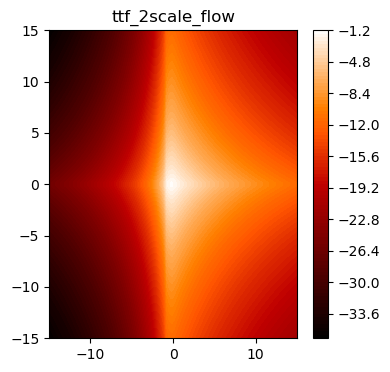

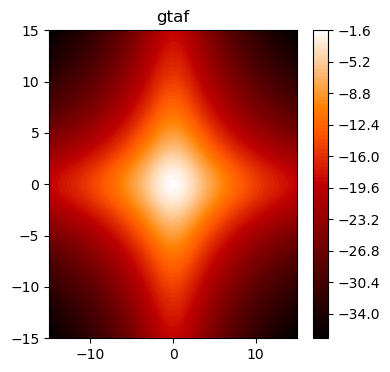

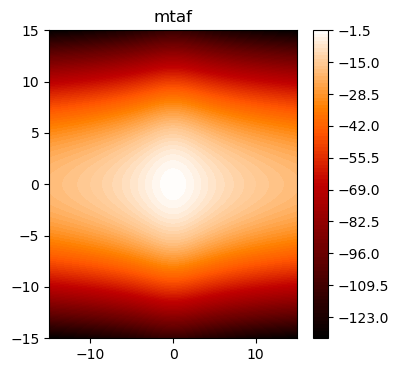

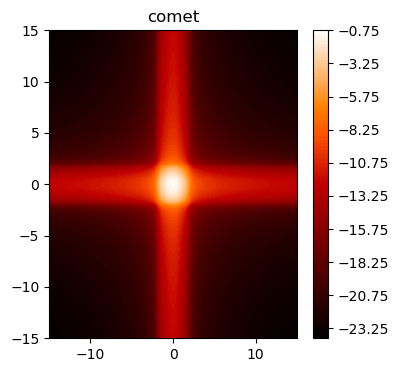

In [9]:
from tailnflows.plot_utils import plot_contour

with torch.no_grad():
    for label, flow in bivariate_flow_models.items():
        fig, ax = plt.subplots(1, 1, figsize=(4,4))
        out, cont = plot_contour(
            ax,
            dim=2,
            target=flow.log_prob,
            min=-15,
            max=15,
            num_levels=100,
            cmap='gist_heat'
        )
        plt.colorbar(cont)
        plt.title(label)
        plt.show()

### Performance
Just try to make sure the VI versions are configured correctly ie are efficient to sample.

In [8]:
data_x = torch.rand([5000, 50])

base_transforms = flows.base_nsf_transform(
    50,
    depth=1,
    tail_bound=3.,
    num_bins=3
)

In [9]:
base_flow_de = flows.build_base_model(
    50,
    "density_estimation",
    base_transformations=base_transforms,
)

base_flow_vi = flows.build_base_model(
    50,
    "variational_inference",
    base_transformations=base_transforms,
)

TypeError: build_base_model() got an unexpected keyword argument 'base_transformations'

In [ ]:
%%timeit
base_flow_de.log_prob(data_x)

35.5 ms ± 634 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
%%timeit
base_flow_vi.sample(data_x.shape[0])

32.8 ms ± 418 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
ttf_flow_de = flows.build_ttf_m(
    50,
    "density_estimation",
    base_transformations=base_transforms,
    model_kwargs=dict(
        pos_tail_init=0.1 * torch.ones([50]),
        neg_tail_init=0.1 * torch.ones([50]),
    )
)

ttf_flow_vi = flows.build_ttf_m(
    50,
    "variational_inference",
    base_transformations=base_transforms,
    model_kwargs=dict(
        pos_tail_init=0.1 * torch.ones([50]),
        neg_tail_init=0.1 * torch.ones([50]),
    )
)

In [ ]:
%%timeit
ttf_flow_de.log_prob(data_x)

40 ms ± 4.25 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
%%timeit
ttf_flow_vi.sample(data_x.shape[0])

43.5 ms ± 5.98 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
gtaf_flow_de = flows.build_gtaf(
    50,
    "density_estimation",
    base_transformations=base_transforms,
    model_kwargs=dict(
        tail_init=10. * torch.ones([50]),
    )
)
gtaf_flow_vi = flows.build_gtaf(
    50,
    "variational_inference",
    base_transformations=base_transforms,
    model_kwargs=dict(
        tail_init=10. * torch.ones([50]),
    )
)

In [ ]:
%%timeit
gtaf_flow_de.log_prob(data_x)

34.7 ms ± 1.05 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
%%timeit
gtaf_flow_vi.sample(data_x.shape[0])

46.1 ms ± 5.73 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
comet_flow_de = flows.build_comet(
    50,
    "density_estimation",
    base_transformations=base_transforms,
    model_kwargs=dict(
        data=torch.distributions.StudentT(10., 0., 1.).sample([1000, 50]),
        fix_tails=True,
        tail_init=0.1 * torch.ones([50])
    )
)

In [ ]:
%%timeit
comet_flow_de.log_prob(data_x)

2.42 s ± 74.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
